In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
print(tf.__version__)

2.13.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#

# !unzip "/content/drive/MyDrive/chest_xray.zip"

In [9]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

image_size = (192, 192)
batch_size = 64

Since we have only two classes we can use binary classification (0 or 1).

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
    )

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    )
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


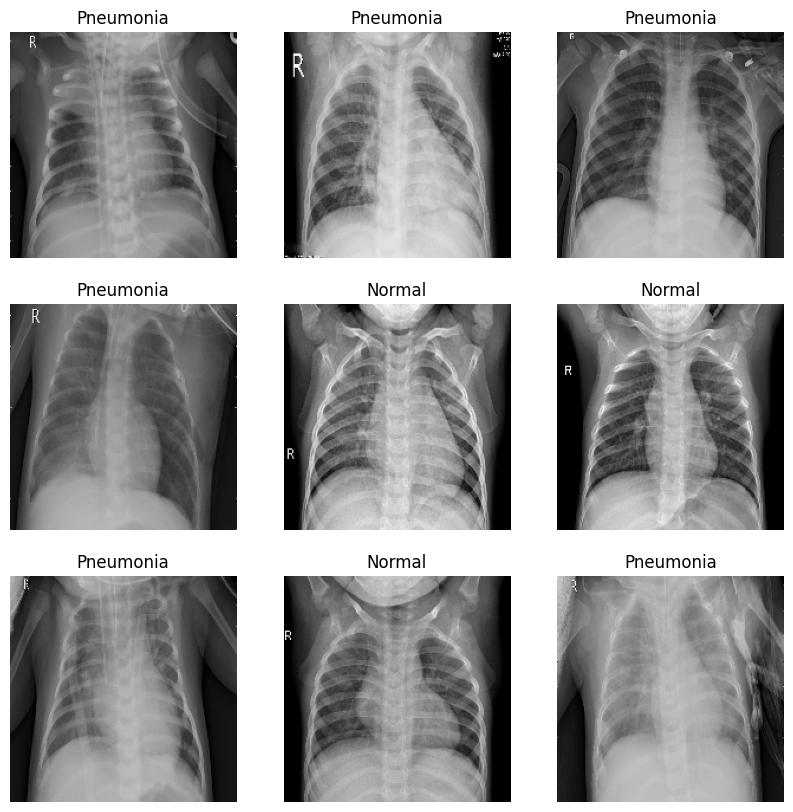

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title( "Pneumonia" if labels[i].numpy().astype("uint8") == 1 else "Normal")
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in test_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 192, 192, 3)
(64, 1)
(64, 192, 192, 3)
(64, 1)
(16, 192, 192, 3)
(16, 1)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [36]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (192, 192, 3), include_top=False, weights = "imagenet")

In [37]:
base_model.trainable = False

In [38]:
inputs = tf.keras.Input(shape = (192, 192, 3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 192, 192, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 192, 192, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)



In [41]:
base_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold = 0, name = "accuracy")])

In [42]:
history = model.fit(train_data, epochs = 6, validation_data = val_data, callbacks=[early_stopping])

Epoch 1/6
82/82 [==============================] - 39s 394ms/step - loss: 0.6215 - accuracy: 0.7105 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 2/6
82/82 [==============================] - 38s 411ms/step - loss: 0.4608 - accuracy: 0.7937 - val_loss: 0.5983 - val_accuracy: 0.5625
Epoch 3/6
82/82 [==============================] - 38s 432ms/step - loss: 0.3655 - accuracy: 0.8466 - val_loss: 0.5300 - val_accuracy: 0.6875
Epoch 4/6
82/82 [==============================] - 35s 396ms/step - loss: 0.3156 - accuracy: 0.8754 - val_loss: 0.5014 - val_accuracy: 0.6875
Epoch 5/6
82/82 [==============================] - 36s 399ms/step - loss: 0.2815 - accuracy: 0.8913 - val_loss: 0.4809 - val_accuracy: 0.6875
Epoch 6/6
82/82 [==============================] - 38s 431ms/step - loss: 0.2566 - accuracy: 0.9016 - val_loss: 0.4623 - val_accuracy: 0.6875


In [43]:
results = model.evaluate(test_data)

10/10 [==============================] - 4s 90ms/step - loss: 0.4168 - accuracy: 0.7821


In [44]:
base_model.trainable = True

In [45]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 40

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [46]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate / 10,
    decay_steps=100,
    decay_rate=0.94,
    staircase=True)

In [47]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name="accuracy")])

In [48]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 192, 192, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 192, 192, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [50]:
fine_tune_epochs = 5
total_epochs =  6 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data, callbacks=[early_stopping])

Epoch 6/11
82/82 [==============================] - 42s 452ms/step - loss: 0.1265 - accuracy: 0.9471 - val_loss: 1.0596 - val_accuracy: 0.6250
Epoch 7/11
82/82 [==============================] - 38s 409ms/step - loss: 0.0724 - accuracy: 0.9712 - val_loss: 0.4324 - val_accuracy: 0.8125
Epoch 8/11
82/82 [==============================] - 38s 433ms/step - loss: 0.0543 - accuracy: 0.9795 - val_loss: 0.4455 - val_accuracy: 0.8125
Epoch 9/11
82/82 [==============================] - 39s 435ms/step - loss: 0.0375 - accuracy: 0.9872 - val_loss: 0.2528 - val_accuracy: 0.8750
Epoch 10/11
82/82 [==============================] - 36s 403ms/step - loss: 0.0318 - accuracy: 0.9879 - val_loss: 0.2082 - val_accuracy: 0.8750
Epoch 11/11
82/82 [==============================] - 38s 409ms/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 0.2231 - val_accuracy: 0.8750


In [51]:
results = model.evaluate(test_data)

10/10 [==============================] - 4s 103ms/step - loss: 0.7085 - accuracy: 0.8365
